## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images and is adapted from Cellpose's Google Drive example (which is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki))

# Initialization
Check GPU and instantiate model - will download weights.

In [7]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
from natsort import natsorted

In [6]:
# Set GPU usage true or false accordingly
USE_GPU = False

io.logger_setup() # run this to get printing of progress
model = models.CellposeModel(gpu=USE_GPU)

2025-07-01 16:16:04,154 [INFO] WRITING LOG OUTPUT TO /Users/michelle.khoo/.cellpose/run.log
2025-07-01 16:16:04,154 [INFO] 
cellpose version: 	4.0.5 
platform:       	darwin 
python version: 	3.10.0 
torch version:  	2.7.0
2025-07-01 16:16:04,155 [INFO] >>>> using CPU
2025-07-01 16:16:04,155 [INFO] >>>> using CPU
2025-07-01 16:16:05,076 [INFO] >>>> loading model /Users/michelle.khoo/.cellpose/models/cpsam


Input directory with your images:

In [ ]:
# *** change to your google drive folder path ***
dir = "/inputs/"
# dir = "/content/drive/MyDrive/INPROG/hb-quant/datasets/control/sub_sample_imgs/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".png"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

1 images in folder:
00000.png


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [ ]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

In [ ]:
flow_threshold = 0.0
cellprob_threshold = -1
tile_norm_blocksize = 0

t0 = time.perf_counter()
masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
t1 = time.perf_counter()
print(f'Generated masks in {t1-t0:.3f}s')

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0])
plt.tight_layout()
plt.show()

NameError: name 'time' is not defined

## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
# masks_ext = ".png" if image_ext == ".png" else ".tif"
# for i in trange(len(files)):
#     f = files[i]
#     img = io.imread(f)
#     masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
#                                   normalize={"tile_norm_blocksize": tile_norm_blocksize})
#     io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
# print("loading images")
# imgs = [io.imread(files[i]) for i in trange(len(files))]

# print("running cellpose-SAM")
# masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
#                                   normalize={"tile_norm_blocksize": tile_norm_blocksize})

# print("saving masks")
# for i in trange(len(files)):
#     f = files[i]
#     io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

to save your masks for ImageJ, run the following code:

In [ ]:
# for i in trange(len(files)):
#     f = files[i]
#     masks0 = io.imsave(dir / (f.name + "_masks" + masks_ext))
#     io.save_rois(masks0, f)

# Run Hb analysis

Define constants and conversions


In [ ]:
# From https://omlc.org/spectra/hemoglobin/summary.html (evaluated at 406nm)
# molar extinction coefficient: 270548 L / (cm * mol) = 270548e3 cm^2 / mol
# Hb has molar mass 64500e12 pg/mol

EPSILON = 270548e3 / 64500e12 # cm^2 / pg

# 2x binning, 30x mag
LEN_PER_PX = 3.45e-4 * 2/ 40 # cm
AREA_PER_PX = LEN_PER_PX ** 2 # cm^2

print(f'LEN_PER_PX = {LEN_PER_PX} cm\nAREA_PER_PX = {AREA_PER_PX:.3e} cm^2 \nEPSILON = {EPSILON:.3e}')

def calc_pg_per_px(absorbance):
    hb_mass = np.multiply(absorbance, AREA_PER_PX  / EPSILON) # pg
    return hb_mass

LEN_PER_PX = 1.725e-05 cm
AREA_PER_PX = 2.976e-10 cm^2 
EPSILON = 4.195e-09


Get filter, background, and cell count

NUM_CELLS = 470
BKG = 217.1708545643749



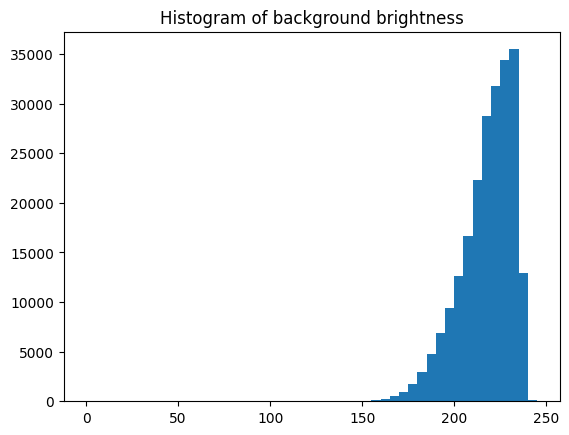

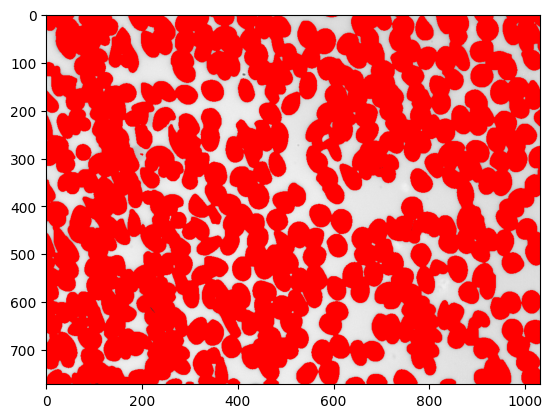

In [ ]:
filt = masks > 0

NUM_CELLS = np.max(masks)
BKG = np.mean(img[~filt])

print(f'NUM_CELLS = {NUM_CELLS}\nBKG = {BKG}\n')

plt.hist(img[~filt], np.arange(0, 250, 5))
plt.title("Histogram of background brightness")

rgb = np.zeros((filt.shape[0], filt.shape[1], 3))
rgb[:, :, 0] = np.multiply(~filt, 255)

import matplotlib.cm as cm

alpha = filt.astype(float)
rgb = np.stack([img, img, img], axis=2)
rgb[filt, :] = [255, 0, 0]

plt.figure()
plt.imshow(rgb, cmap=cm.jet)

Rescale image to compute absorbance

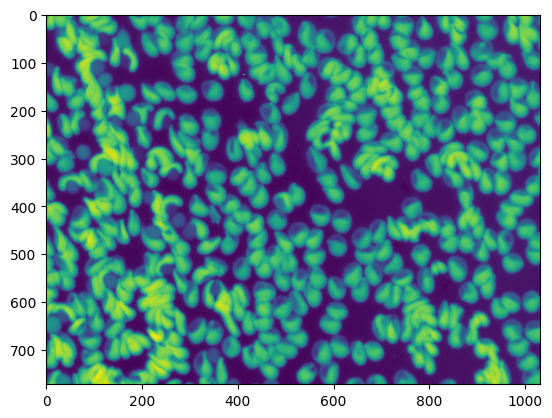

In [ ]:
absorbance_img = np.log10(BKG/img)
# plt.imshow(absorbance_img)

pg_img = calc_pg_per_px(absorbance_img)
plt.imshow(pg_img)

Mean MCH = 32.924 pg


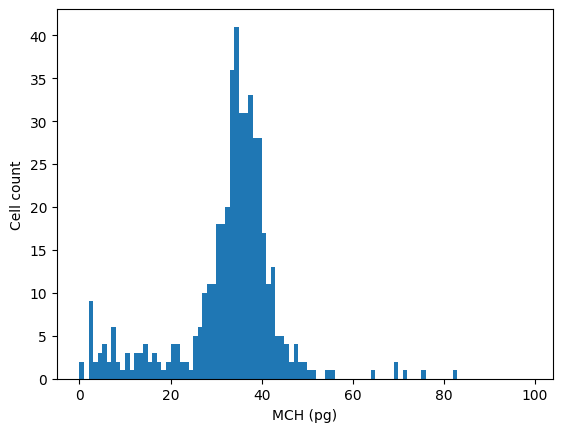

In [ ]:
MCHs = [np.sum(pg_img[masks == cell_id]) for cell_id in range(NUM_CELLS)]

print(f'Mean MCH = {np.mean(MCHs):.3f} pg')

max_bin = 100
plt.hist(MCHs, bins=np.arange(0, max_bin, max_bin / 100))
plt.ylabel("Cell count")
plt.xlabel("MCH (pg)")
plt.show()

# Run Hb pipeline from batch processing

In [ ]:
px_mapping_df = pd.read_csv('px_map_c0_0p39039.csv')
px_mapping = np.array(px_mapping_df['px_mapped'])

EPSILON = 270548e3 / 64500e12 # cm^2 / pg

# 2x binning, 30x mag
LEN_PER_PX = 3.45e-4 * 2/ 40 # cm
AREA_PER_PX = LEN_PER_PX ** 2 # cm^2

# print(f'\nLEN_PER_PX = {LEN_PER_PX} cm\nAREA_PER_PX = {AREA_PER_PX:.3e} cm^2 \nEPSILON = {EPSILON:.3e}')

def calc_pg_per_px(absorbance):
    hb_mass = np.multiply(absorbance, AREA_PER_PX  / EPSILON) # pg
    return hb_mass

In [8]:
def get_img_hb():
    # mapped_img = px_mapping[img]
    mapped_img = img

    filt = masks > 0
    NUM_CELLS = np.max(masks)
    BKG = np.mean(mapped_img[~filt])
    BKG_STD = np.std(mapped_img[~filt])
    # print(f'NUM_CELLS = {NUM_CELLS}\nBKG = {BKG}\n')

    absorbance_img = np.log10(BKG / mapped_img)
    pg_img = calc_pg_per_px(absorbance_img)

    mchs = [np.sum(pg_img[masks == cell_id]) for cell_id in range(NUM_CELLS)]
    avg_mch = np.mean(mchs)
    std_mch = np.std(mchs)
    # print(f'Per image MCH  = {avg_mch:.3f} pg')

    return avg_mch, std_mch, NUM_CELLS, BKG, BKG_STD, mchs

In [ ]:
avg_mch, std_mch, NUM_CELLS, BKG, BKG_STD, mchs = get_img_hb()

print(f'BKG = {BKG:.2f}\nBKG STD = {BKG_STD:.2f}')

BKG = 588.32
BKG STD = 39.03


44.67 pg for cell 40


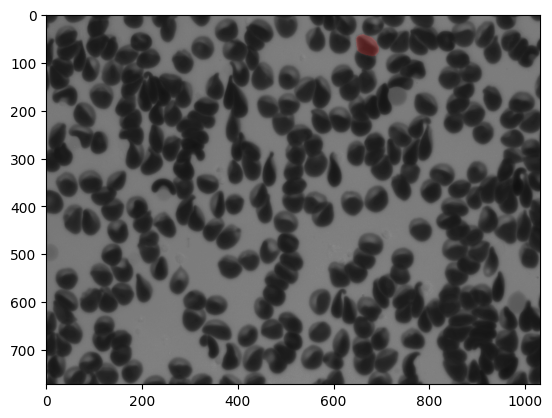

In [ ]:
cell_id = 40

print(f'{mchs[cell_id]:.2f} pg for cell {cell_id}')
plt.imshow(px_mapping[img], cmap='gray', vmin=0, vmax=1000)

h, w = img.shape

cell_filt = (masks==cell_id).reshape(h, w)

red_img = np.zeros((h, w, 3), dtype=np.uint8)
red_img[cell_filt] = [255, 0, 0]

plt.imshow(red_img, alpha=0.2)

In [ ]:
plt.imshow(px_mapping[img], cmap='gray', vmin=0, vmax=1000)
plt.figure()
plt.imshow(img, cmap='gray', vmin=0, vmax=1000)

NameError: name 'plt' is not defined